# CDR Experiments via Pymagicc
##### CC-BY 4.0 2020 @safiume
#### https://github.com/hsbay/cdrmex

In [1]:
# NBVAL_IGNORE_OUTPUT
import sys, re
from os import listdir
from os.path import join, dirname
from pprint import pprint
import expectexception
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline
import f90nml

In [2]:
#Disable warning supression if running locally
import warnings
warnings.simplefilter("ignore", category=Warning, lineno=0, append=False)

In [3]:
import pymagicc
from pymagicc import MAGICC6
from pymagicc.io import MAGICCData, read_cfg_file, NoReaderWriterError
from pymagicc.scenarios import ( rcp26, rcp45, zero_emissions )
from scmdata import run_append
print(pymagicc.__version__)
print(sys.version)
rcp26.__class__.__bases__

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


2.0.0rc8+19.g7aade1e.dirty
3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


(scmdata.run.ScmRun,)

In [4]:
pd.set_option("precision", 4)
## List of experiments in declines
declines = ["emax", "lmax", "emin", "lmin"]
SCEN_DIR = "SCEN"
MAGICC6_DIR = join("..", "CDRRUN")

# Net Zero Start Year
nzst = 2035
# Emissions End
effend = 2100

# The baseline for 0 °C will be recalculated based the mean
# temp for 1720-1800, which roughly equals temp at 1786.
# 1786 can be used as a convience for the series start
# and if so increases Anthropogenic inventory by 22.107 GtC.
# It also moves the CO₂ baseline of 277 ppm to 284.80 ppm.
# Baseline temp to the mean of 1720 to 1800 are per
# https://doi.org/10.1175/BAMS-D-16-0007.1
zero_out_temp_start = 1720
zero_out_temp_end = 1800

# set core_climatesensitivity set MAGICC6 to emulate the CMIP6
# test abrupt-0p5xCO2 = { 'MRI-ESM2-0' : 1.7931,
#                         'HadGEM3-GC31-LL' : 2.6144, 
#                         'GISS-E2-1-G' : 1.6186
#                        }

## Start of MAGICC settings
magcfg = {'startyear' : 1750,                        # Include 1750 for NE calibration, per MAGICC 
          'endyear' : 2662,
          'core_climatesensitivity' : 3.6,           # 3.6 K best linefits for 2015-2020 Current Temps
          #'co2_tempfeedback_yrstart' : 2005,
          #'co2_fertilization_yrstart' : 2005,
          'co2_switchfromconc2emis_year' : 2005,
          'rf_total_constantafteryr' : 5000,         # Affects overall warming & ppm, via N2O
          'rf_tropoz_constantafteryr' : 5000,
          'rf_stratoz_constantafteryr' : 5000,
          'rf_mhalo_constantafteryr' : 5000,
          'rf_fgas_constantafteryr' : 5000,
          'rf_landuse_constantafteryr' : 5000,       # Affects warming by lowing CO2 ppm into land-sink
          'rf_mineraldust_constantafteryr' : 2070,   # mineraldust affects indirect aerosol forcing
          'n2o_switchfromconc2emis_year': 2005,
          'fgas_switchfromconc2emis_year': 2005,
          'mhalo_switchfromconc2emis_year' : 2008,
          'mhalo_switch_conc2emis_yr' : 2008,
          'out_forcing' : 1,
          'out_emissions' : 1,
          'out_concentrations' : 1,
          'out_temperature' : 1,
          'out_warnings': 1,
          'out_misc': 1,
         }
### End MAGICC Settings

# MAGICC6 Forcing Issues
#  Indirect Aerosols persist positively after FF is stopped. 
#  Mineral dust forcing causes an increase in Indirect Aerosols 
#   well past 2500.
#  Need to find the setting to halt N2O emissions after restoring
#   to preindustry levels.
#  F, and Halo carbons force the odd spike even though those are
#   set to decrease by Montreal Protocol/Kigali Amment. A few 
#   continue to have positive forcing past their emission lifetime.

Import IMAGE-SSP1-1.9 from manually imported SCEN built from 
"IMAGE 3.0.1","SSP1-19","World","Diagnostics|MAGICC6|Harmonized Input|*

© IAMC 1.5°C Scenario Explorer hosted by IIASA https://data.ene.iiasa.ac.at/iamc-1.5c-explorer

There are some artifacts in the dataset and subsequent graphs as the download was missing the full fgasses and halo gasses.

In [5]:
# Reassign startyear to include the year 1720.
graphstart = magcfg['startyear']
if magcfg['startyear'] > zero_out_temp_start:
    magcfg['startyear'] = zero_out_temp_start

In [6]:
## load experiments scen file data
for n, name in enumerate (declines):
    declinefile = join(SCEN_DIR, "ONC" + name + ".SCEN")
    declines[n] = MAGICCData(declinefile,
                             columns={"model": ["CDRex"], "scenario": [name]})

img119 = MAGICCData(join(SCEN_DIR, 'imgs119.SCEN'), 
                    columns={"model": ["IMAGE"], "scenario": ['SSP119']}, inplace=True)
declines.append(img119)

# Copy lmin data into new experiment
CCCx2050 = declines[3]

In [7]:
CCC_df = CCCx2050.timeseries()
CCC_df = CCC_df.rename(index={"lmin":"CCCx2050"})

In [8]:
# Calculate how much carbon to remove to achieve 300 ppm at 2050

CRsyr = 2030
Bkyr = 2050

# Temp at 1850 = 0 K relative to mean of 1720-1800

#anth1786 = .13           # GCB = .13 GtC
#atm1786 = 5.46           # GCB ATM 1750-1786 

# Anthropogenic Fossil Fuel Emissions 
# CO₂ gas in GtC
AnthroC = 482.2401

# Anthropogenic Land-use Change Emissions
# CO₂ gas in GtC
LuC =  195.3414          # MAGICC Cumulative LUC

# minus for differences between landsink and LUC
# from the time MAGICC was created to the present?

# to 300 ppm
AC_2050 =  257           #237 low model sensitiv x<2.6
LuC_2050 = 54.54         # <2.73 

# Remove imbalance and LUC overage from AnthroC
# GCB 2020, and rounding errors. And post
# 2100-2500 land sink productivity? Current
# skew will push up final CO2 ppm

skew = 0 #14 # + anth1786 + atm1786  # GCB-2020 18.95

In [9]:
# gas defination helpers
ems_ff = 'Emissions|CO2|MAGICC Fossil and Industrial'
ems_luc = 'Emissions|CO2|MAGICC AFOLU'
methane = 'Emissions|CH4'
emsf = ('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr', ems_ff)
emsluc = ('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr', ems_luc)

In [10]:
# Zero anthro data past 2010 
CCC_df.loc[emsf, datetime(2010,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_df.loc[emsluc, datetime(2010,1,1,0) : datetime(2150,1,1,0)] = 0

In [11]:
ki_mo_ghgs_F = [ 'HFC134a', 'HFC245fa', 'HFC227ea', 'HFC4310', 'HFC32', 'HFC125', 'HFC143a', 'HFC23' ]

#Inc Kigali/MontrealP GhG years
timepts = {
    'kigyr1' : [2019, .998],
    'pkyr' : [(CRsyr - 1), 1],
    'kigyr2' : [2024, .95], 
    'kigyr3' : [2025, .65],
    'kigyr4' : [2029, .30],
    'kigyr5' : [2034, .20],
    'sf6eu' : [2030, .30],
    'kigyr6' : [2036, .15],
    'edyr' : [effend, 0.00]
}
timepts.update({ 'CRsyr': [CRsyr, .97 ], 'Bkyr': [Bkyr, 0] })
timepts = pd.DataFrame(timepts,['year','NtZeroPcnt']).T
timepts = timepts.sort_values(by='year')

#Net Zero Dates - zero emissions for non CO2 gasses
n0dates = [nzst, effend]

# harmonize to GCB(2020) FF+luc Ghg
# https://doi.org/10.18160/GCP-2020, 9.4 est 2021
# [2010-2023]
FF=[9.04, 9.34, 9.49, 9.55, 9.62, 9.61, 9.61, 9.74, 9.94, 9.95, 9.3, 9.4, 6, 0]
# 2005, [2010-2021]
luc=[1.42, 1.46, 1.38, 1.49, 1.53, 1.65, 1.70, 1.56, 1.52, 1.55, 1.80, 1.6, 1]

In [12]:
def dtspn(emm,dates,vals,df):
    if type(emm) == str:
        ndf = df.xs(emm, level = 'variable', drop_level = False)
    else :
        ndf = df.loc[:,:,:,:,:,:,emm]
    row = ndf.index.values
    ndf.at[row, datetime(dates[0],1,1) : datetime(dates[1],1,1)] = vals
    df.loc[ndf.index.values] = ndf 
    return df

def kigali(ki_ghgs,df):
    kgfs = []
    for kgs in ki_ghgs:
        kgs = ('Emissions|') + kgs
        kgfs.append(kgs)
    ndf = df.loc[:,:,:,:,:,:,kgfs]
    row = ndf.index.values
    mxyr = int(timepts.loc['pkyr'][0])    
    for i, tmpt in enumerate(timepts['year']):
        if tmpt < (timepts['year'].max()):
            tmpt = int(tmpt)
            nxtyr = int(timepts.iloc[[i+1],0])
            rate = timepts.iloc[[i],1].values
            rates = ndf.loc[:, datetime(mxyr,1,1,0)] * rate
            srws = ndf.loc[row, datetime(tmpt,1,1,0) : datetime(nxtyr,1,1,0)]
            srws.apply(lambda x: x * rates.values)
    df.loc[row] = ndf
    return df

def decline(ems, dates, xrate, df):
    ndf = df.xs(ems, level = 'variable', drop_level = False)
    row = ndf.index.values
    slc = ndf.loc[row, datetime(dates[0],1,1):datetime(dates[1],1,1)]
    slc.apply(lambda x: x * xrate)
    df.loc[ndf.index.values] = ndf
    return df

df = CCC_df.copy()
dates = [2010, 2023]
df = dtspn( ems_ff, dates, FF, df)
dates = [2005, 2021]
df = dtspn( ems_luc, dates, luc, df)
df = kigali(ki_mo_ghgs_F, df)
xrate = -0.336
dates = [2021, 2049]
df = decline(methane, dates, xrate, df)
dates = [2022, 2028]
ffvals = np.linspace(6,-9.2,(2028-2022+1))
df.loc[emsf,datetime(dates[0],1,1):datetime(dates[1],1,1)] = ffvals
df.loc[emsf,datetime(2029,1,1)] = -9.2
dates = [2022, 2029]
lucvals = np.linspace(0,-2.72,(2029-2022+1))
df.loc[emsluc,datetime(dates[0],1,1):datetime(dates[1],1,1)] = lucvals
# strip CO₂ FF, Luc, NH3 from index.values
net0 = df.index.get_level_values(6)[[2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22]]
val = (0)
df = dtspn( net0, n0dates, val, df)

CCC_df = df.copy()

#df.style #print copy for diags
#df.loc[:,datetime(2005,1,1,0):datetime(2035,1,1,0)].style

In [13]:
# remove -FF emissions up to CRsyr = 2030
AnthroC2029 = AnthroC + CCC_df.loc[emsf,datetime(2025,1,1):datetime(CRsyr-1,1,1)].T.sum()
# remove -FF from LUC 2022-2029
LuC2029 = LuC + (sum(lucvals))

# calculate to 300 ppm
landsnk_yrly = LuC_2050/((Bkyr) - CRsyr)
landsnc_remainingYr = (LuC2029 - LuC_2050)/50
Peak_to_bk_yr = AC_2050/((Bkyr) - CRsyr)
Remaining_per_yr = (AnthroC2029 - AC_2050 - skew)/50

# Set removal according to forumlas in previous cell
CCC_df.loc[emsluc, datetime(CRsyr,1,1) : datetime(2049,1,1)] = -landsnk_yrly
CCC_df.loc[emsluc, datetime(2050,1,1) : datetime((effend-1),1,1)] = -landsnc_remainingYr
CCC_df.loc[emsf, datetime(CRsyr,1,1) : datetime(2049,1,1)] = -Peak_to_bk_yr
CCC_df.loc[emsf, datetime(2050,1,1) : datetime((effend-1),1,1)] = -Remaining_per_yr

In [14]:
#Diags
print('AnthroC is                                    ', AnthroC)
print('Anthro Emissions to 2025                         {:.4f}'.format(
         CCC_df.loc[emsf,datetime(2025,1,1):].T.sum() + AnthroC ))
print('Anthro Emissions plus AnthroC - skew             {:.4f}'.format(       
         CCC_df.loc[emsf,datetime(2030,1,1):].T.sum() + AnthroC2029 ))
print('\n')
print('LandUseChange is                              ', LuC)
print('LandUseChange Emissions to 2022               {:.4f}'.format(
        CCC_df.loc[emsluc,datetime(2022,1,1):].T.sum()))
print('LanduseChange Emiss plus LandUseC inventory      {:.4f}'.format(
        CCC_df.loc[emsluc,datetime(2022,1,1):].T.sum() + LuC))
#CCC_df.style #print copy for diags

AnthroC is                                     482.2401
Anthro Emissions to 2025                         0.0000
Anthro Emissions plus AnthroC - skew             0.0000


LandUseChange is                               195.3414
LandUseChange Emissions to 2022               -195.3414
LanduseChange Emiss plus LandUseC inventory      0.0000


In [15]:
# Rewrite CCCx2050 from timeseries and wrap in MAGICCData
CCCx2050 = MAGICCData(CCC_df.copy())
#CCCx2050.write(join(SCEN_DIR,'CCCx2050.SCEN'),magicc_version=6)
#CCC_df.to_csv('CCCx2050.csv')

CCC_flat = CCC_df.copy()
CCC_flat.loc[emsf, datetime(2051,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_flat.loc[emsluc, datetime(2051,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_flat = CCC_flat.rename(index={"CCCx2050":"CCCxflat"})
CCCxflat = MAGICCData(CCC_flat.copy())

In [16]:
print("Diagnostic Output")
for n in 10,20,21,42:
    print(CCC_df.head(2).iloc[:,n])
    print("GtCO₂ FF & LUC\t", CCC_df.head(2).iloc[:,[n]].values.T * 3.664)
#CCCx2050.timeseries().loc[:,datetime(2020,1,1,0) : datetime(2101,1,1,0)].head(23).style

Diagnostic Output
climate_model  model  region  scenario  todo  unit       variable                                  
unspecified    CDRex  World   CCCx2050  SET   Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    9.95
                                                         Emissions|CO2|MAGICC AFOLU                    1.80
Name: 2019-01-01 00:00:00, dtype: float64
GtCO₂ FF & LUC	 [[36.4568  6.5952]]
climate_model  model  region  scenario  todo  unit       variable                                  
unspecified    CDRex  World   CCCx2050  SET   Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial   -9.20
                                                         Emissions|CO2|MAGICC AFOLU                   -2.72
Name: 2029-01-01 00:00:00, dtype: float64
GtCO₂ FF & LUC	 [[-33.7088   -9.96608]]
climate_model  model  region  scenario  todo  unit       variable                                  
unspecified    CDRex  World   CCCx2050  SET   Gt C / yr  Emissions|CO2|MAGICC Fossil and I

In [17]:
pd.get_option("precision")

4

In [18]:
# Force sample rcp26 to end CR at 2101
rcp26df = rcp26.timeseries()
rcp26df = rcp26df.rename(columns={datetime(2125,1,1,0):datetime(2101,1,1,0)})
rcp26df.loc[:, datetime(2101,1,1,0) : datetime(2500,1,1,0)] = 0
rcp26 = MAGICCData(rcp26df.copy())

# Scenarios

The five RCP scenarios and experimental declines are loaded as DataFrames in pyhector. They contain the following emissions:

In [ ]:
rcp26.filter(region='World').timeseries().loc[:,datetime(2090,1,1,0):datetime(2101,1,1,0)].tail(4)

In [ ]:
rcp26.head(2)

They are split up in regions:

In [ ]:
rcp26["region"].unique()

They have the following units:

In [ ]:
#pymagicc.units
#rcps[["variable", "unit"]].drop_duplicates()
rcp26["unit"].head()

In [ ]:
categories_to_plot = rcp26["variable"].drop_duplicates().tolist()

for g in rcp26.filter(
    variable=categories_to_plot,
    year=range(2000, 2150)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="region").set_title(g.get_unique_meta("variable", True))

In [ ]:
categories_to_plot = CCCx2050["variable"].drop_duplicates().tolist()

for g in CCCx2050.filter(
    variable=categories_to_plot,
    year=range(2000, 2101)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="region").set_title(g.get_unique_meta("variable", True))

# Fossil fuel emissions for the five RCP scenarios and Experimental Declines.

In [ ]:
x = (datetime(2000, 1, 1), datetime(magcfg["endyear"], 1, 1))
pret="OpenCDR & RCP experimental scenarios for "
gtgvar = "*CO2|MAGICC Fossil and Industrial", "*CO2|MAGICC AFOLU*"
mtgvar = "*Emissions|CH4", "*Emissions|CO"
list = [gtgvar,mtgvar]
title = [pret + "Fossil Fuel emissions (CO₂)", 
         pret + "Methane & Carbon Monoxide (CH4, CO)"]
declines.append(CCCx2050)
mdata = MAGICCData(rcp26)
for scen in declines:
    mdata = mdata.append(scen)
fig, axes = plt.subplots(2,1, figsize = (16, 10))
for n,var in enumerate(list):
    varun = var[(n-1)]
    test = mdata.filter(region="World", variable=var).lineplot(hue="scenario", style="variable", ax=axes[n])
    ylab = declines[0].filter(region="World", variable=varun)["unit"].iloc[[0]].all()
    if ylab == 'K':
        ylab = '°C'
    axes[n].set_ylabel(ylab)
    axes[n].set_title(title[n])
    axes[n].set_xlim(x)

## Running MAGICC

A single `pymagicc` run doesn't take long and returns a Pandas Dict.
(If not on Windows, the very first run might be slower due to setting up Wine.)

In [19]:
pd.set_option("precision", 4)

In [20]:
# Diags to run MAGICC
#%time results = pymagicc.run(rcp26)
#results = ""
#%time results = pymagicc.run(declines[0].filter(), **magcfg)
#results = ""
#%time results = pymagicc.run(rcp26, **magcfg)
#slice = results.filter(region="World",variable="Radiative Forcing")["unit"].head(3)

In [21]:
# Adjust baseline temp to the mean of 1720 to 1800 
# per https://doi.org/10.1175/BAMS-D-16-0007.1

styr = zero_out_temp_start
eyr = zero_out_temp_end
sitv = magcfg['core_climatesensitivity']
lsitv = (sitv - 1.25)
lsitv = float('{:1.4}'.format(lsitv))
hsitv = (sitv + 1.25)
hsitv = float('{:1.4}'.format(hsitv))
selectftr = {
    'region': 'World',
    'variable': 'Surface Temperature',
    'year': range(magcfg['startyear'], magcfg['endyear']),
}

In [22]:
# Mean baseline function

# Could be removed if the following 
# can be reset in magcfg:
#   out_zero_temp_period = 1961, 1990
#   out_zero_heat_period = 1961, 1990
# check the literature if zero_heat_period 
# should be moved in parallel.
    
def meanbln(scen,mgdata,**cfgs):
    pd.set_option("precision", 4)
    origts = mgdata.timeseries()
    default = pymagicc.run(scen, **cfgs)
    pmean = default.filter(**selectftr).timeseries().loc[:,datetime(styr, 1, 1): datetime(eyr, 1, 1)].T.mean()
    defaultts = default.timeseries()
    updated = defaultts.xs((selectftr['variable']),level = ('variable'), drop_level=False).sub(pmean[0])
    origts.loc[updated.index.values] = updated
    return(MAGICCData(origts.copy()))

In [23]:
clvars = ["Surface Temperature", "Radiative Forcing", "Atmospheric Concentrations|CO2 Equivalent"]
nrvars = ["Atmospheric Concentrations|CO2", "Atmospheric Concentrations|N2O"]
vars = clvars + nrvars + [ "Emissions|CO2|MAGICC Fossil and Industrial", 
                          "Emissions|CO2|MAGICC AFOLU", 
                          "CLIMSENS_EFF",
                          "CLIMSENS_EQ"]
#x = (datetime(1700, 1, 1), datetime(magcfg["endyear"], 1, 1))
x = (datetime(1850, 1, 1), datetime(2125, 1, 1))

In [24]:
#res = ''
#%time res = pymagicc.run(rcp26, **magcfg)  #need to create res of type MAGICCData
#res = meanbln(rcp26,res,**magcfg)

# Toggle to run and graph all the experiments
#declines.append(CCCxflat)
#declines.append(CCCx2050)

#for scen in declines:
#    tmprs = pymagicc.run(scen, **magcfg)
#    res = res.append(meanbln(scen, tmprs, **magcfg))

In [25]:
# Current Graphs
res = ''
tmprs = pymagicc.run(CCCx2050, **magcfg)
res = meanbln(CCCx2050,tmprs,**magcfg)

#res = pymagicc.run(CCCx2050, **magcfg)

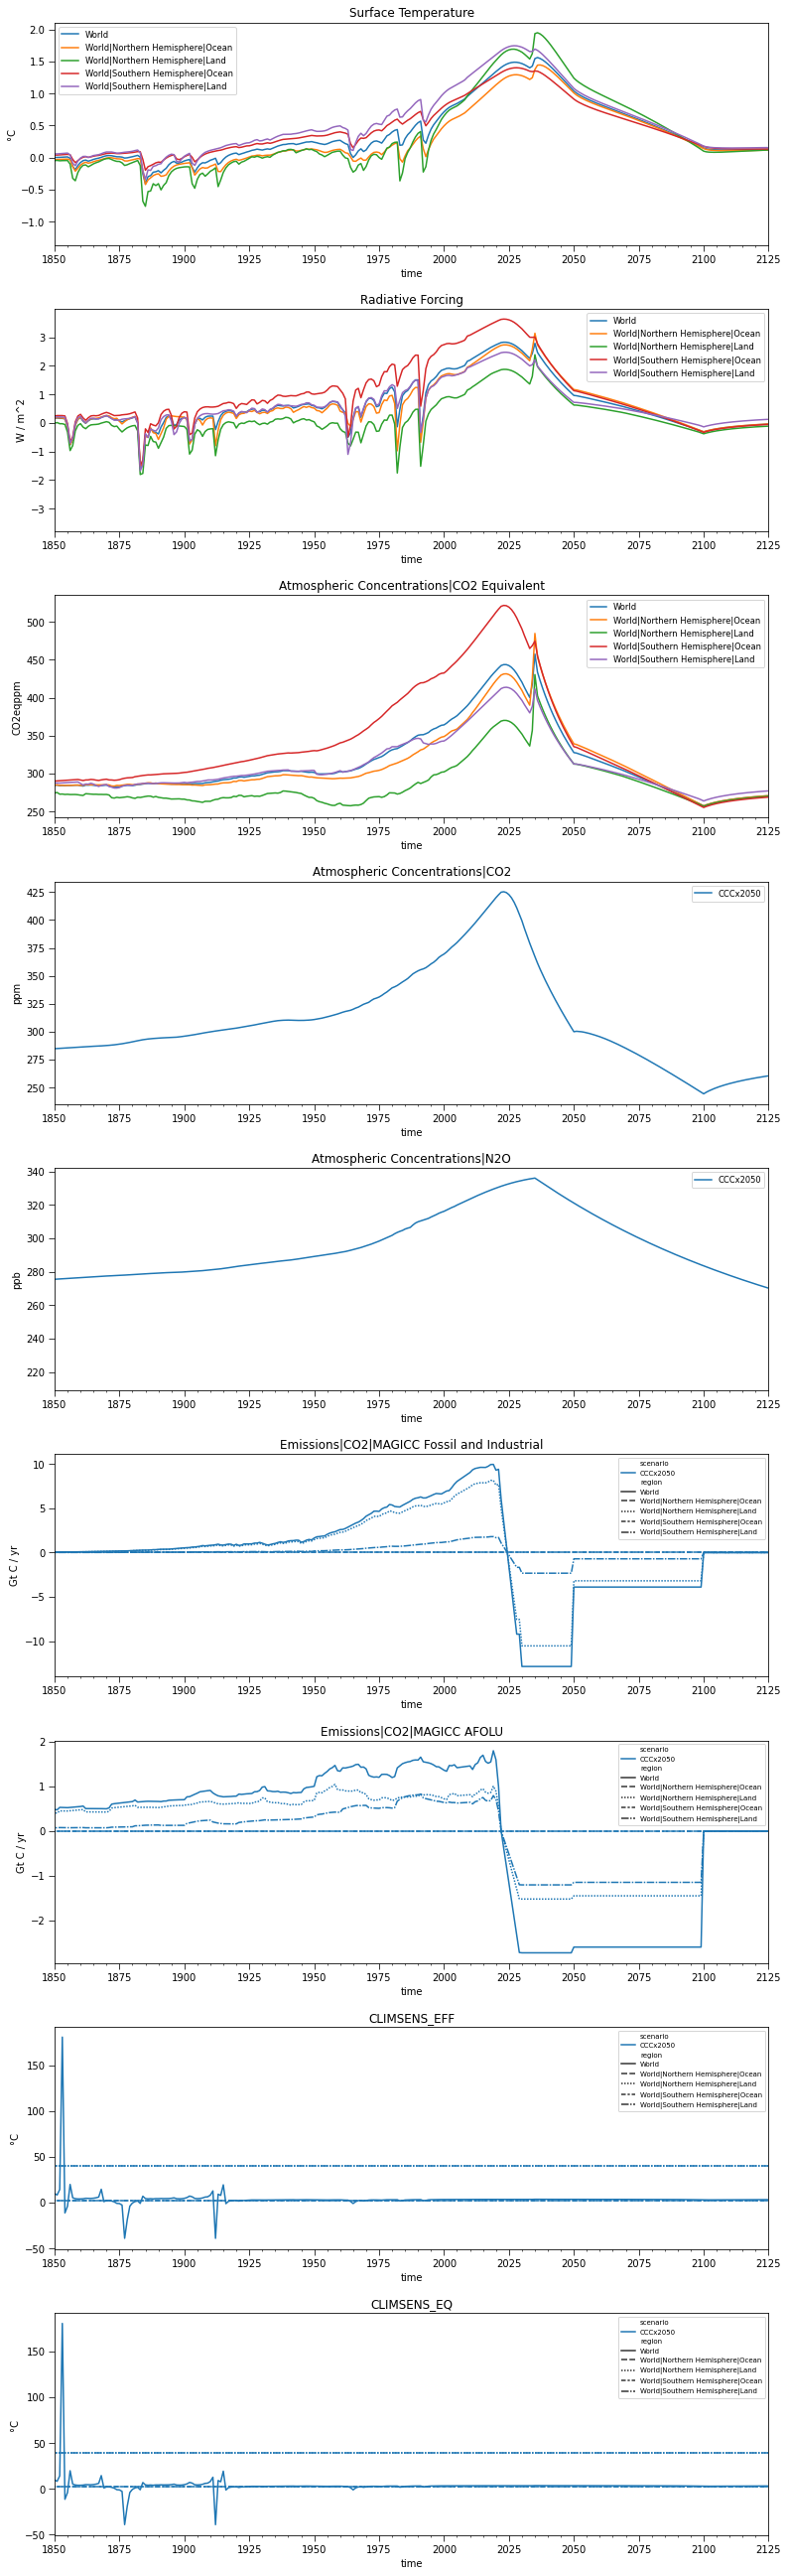

In [26]:
locator = mdates.YearLocator(25, month=1, day=1)
formatter = mdates.ConciseDateFormatter(locator)

fig, axes = plt.subplots((len(vars)), 1, figsize=(11, 36))
for n, var in enumerate(vars):
    if var in clvars:
        res.filter(variable=var).lineplot(ax=axes[n], hue='region')
        ftsize="small"
    elif var in nrvars:
        res.filter(variable=var, region="World").lineplot(ax=axes[n], hue='scenario')
        ftsize="small"
    else:
        res.filter(variable=var).lineplot(ax=axes[n], style='region')
        ftsize="x-small"
    axes[n].legend(loc='best', fontsize=ftsize)
    ylab = res.filter(variable=var)["unit"].iloc[[0]].all()
    if ylab == 'K':
        ylab = '°C'
    axes[n].set_ylabel(ylab)
    axes[n].set_title(var)                        
    axes[n].set_xlim(x)
    axes[n].tick_params(which='major', width=0.75, length=6)
    axes[n].xaxis.set_major_locator(locator)
    axes[n].xaxis.set_major_formatter(formatter)
    axes[n].xaxis.set_minor_locator(ticker.LinearLocator(numticks=56))
    plt.tight_layout(pad=0.6, h_pad=1.5)


In [27]:
plt.close('all')


# Diagnostic Output

In [28]:
mnbls = {
    'mnt1720_1800': [ 1720, 1800 ],
    'mnt1850_1900': [ 1850, 1900 ],
    'mnt1861_1900': [ 1861, 1900 ],
    'mnt1880_1900': [ 1880, 1900 ],
    'mnt1961_1990': [ 1961, 1990 ] }

for key in mnbls.keys():
    mn = res.filter(scenario = 'CCCx2050', variable = ["Surface Temperature", 
                    "Atmospheric Concentrations|CO2"], region='World').timeseries().xs([
                    'MAGICC6','CDRex','CCCx2050','World','not_relevant'], 
                    level = ['climate_model','model','scenario','region','todo']).loc[
                    :,datetime(mnbls[key][0],1,1):datetime(mnbls[key][1],1,1)].T.mean()
    print("Mean {} {} {}".format(mnbls[key][0], mnbls[key][1], mn))

Mean 1720 1800 unit  variable                      
ppm   Atmospheric Concentrations|CO2    2.7862e+02
K     Surface Temperature               1.0708e-18
dtype: float64
Mean 1850 1900 unit  variable                      
ppm   Atmospheric Concentrations|CO2    289.8765
K     Surface Temperature                -0.0694
dtype: float64
Mean 1861 1900 unit  variable                      
ppm   Atmospheric Concentrations|CO2    291.0738
K     Surface Temperature                -0.0760
dtype: float64
Mean 1880 1900 unit  variable                      
ppm   Atmospheric Concentrations|CO2    293.9143
K     Surface Temperature                -0.1411
dtype: float64
Mean 1961 1990 unit  variable                      
ppm   Atmospheric Concentrations|CO2    333.5193
K     Surface Temperature                 0.2602
dtype: float64


In [29]:
mnt1961_1990 = res.filter(scenario = 'CCCx2050', variable = "Surface Temperature", 
                         region='World').timeseries().xs([
                    'MAGICC6','CDRex','CCCx2050','World','not_relevant'], 
                    level = ['climate_model','model','scenario','region','todo']).loc[
    :,datetime(1961,1,1):datetime(1990,1,1)].T.mean()
print("Mean 1961 - 1990", mnt1961_1990)
res.filter(scenario = 'CCCx2050', variable = "Surface Temperature", 
                         region='World').timeseries().xs([
                    'MAGICC6','CDRex','CCCx2050','World','not_relevant'], 
                    level = ['climate_model','model','scenario','region','todo']).loc[
    :,datetime(1961,1,1)]

Mean 1961 - 1990 unit  variable           
K     Surface Temperature    0.2602
dtype: float64


unit  variable           
K     Surface Temperature    0.242
Name: 1961-01-01 00:00:00, dtype: float64

In [30]:
res.filter(variable = 'Surface Temperature').timeseries().xs([
                    'MAGICC6','CDRex','CCCx2050','not_relevant'], 
                    level = ['climate_model','model','scenario','todo']).loc[:,datetime(2005,1,1):].T.min()

region                           unit  variable           
World                            K     Surface Temperature    0.0567
World|Northern Hemisphere|Ocean  K     Surface Temperature    0.0521
World|Northern Hemisphere|Land   K     Surface Temperature    0.0577
World|Southern Hemisphere|Ocean  K     Surface Temperature    0.0540
World|Southern Hemisphere|Land   K     Surface Temperature    0.0721
dtype: float64

In [31]:
mx = res.filter(variable = 'Surface Temperature').timeseries().xs([
                    'MAGICC6','CDRex','CCCx2050','not_relevant'], 
                    level = ['climate_model','model','scenario','todo']).loc[:,datetime(2005,1,1):].T.max()
mx

region                           unit  variable           
World                            K     Surface Temperature    1.5628
World|Northern Hemisphere|Ocean  K     Surface Temperature    1.4469
World|Northern Hemisphere|Land   K     Surface Temperature    1.9500
World|Southern Hemisphere|Ocean  K     Surface Temperature    1.4032
World|Southern Hemisphere|Land   K     Surface Temperature    1.7474
dtype: float64

In [32]:
res.filter(variable = 'Surface Temperature').timeseries().xs([
    'MAGICC6','CDRex','CCCx2050','not_relevant','Surface Temperature'], 
    level = ['climate_model','model','scenario','todo','variable']).loc[:,datetime(2015,1,1):datetime(2025,1,1)]

,time,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,2020-01-01 00:00:00,2021-01-01 00:00:00,2022-01-01 00:00:00,2023-01-01 00:00:00,2024-01-01 00:00:00,2025-01-01 00:00:00
region,unit,,,,,,,,,,,
World,K,1.1669,1.2028,1.2386,1.2746,1.3095,1.3431,1.3761,1.4080,1.4354,1.4575,1.4742
World|Northern Hemisphere|Ocean,K,0.9506,0.9878,1.0253,1.0630,1.0999,1.1352,1.1692,1.2020,1.2310,1.2548,1.2734
World|Northern Hemisphere|Land,K,1.2675,1.3195,1.3715,1.4237,1.4722,1.5175,1.5617,1.6042,1.6384,1.6647,1.6828
World|Southern Hemisphere|Ocean,K,1.1526,1.1779,1.2033,1.2287,1.2541,1.2796,1.3048,1.3294,1.3516,1.3701,1.3848
World|Southern Hemisphere|Land,K,1.4471,1.4793,1.5114,1.5434,1.5755,1.6076,1.6394,1.6704,1.6967,1.7178,1.7335


In [33]:
res.filter(variable = 'Surface Temperature').timeseries().xs([
                    'MAGICC6','CDRex','CCCx2050','not_relevant'], 
                    level = ['climate_model','model','scenario','todo']).loc[:,datetime(2102,1,1):datetime(2107,1,1)].style

,,time,2102-01-01 00:00:00,2103-01-01 00:00:00,2104-01-01 00:00:00,2105-01-01 00:00:00,2106-01-01 00:00:00,2107-01-01 00:00:00
region,unit,variable,,,,,,
World,K,Surface Temperature,0.1302,0.1259,0.1231,0.1212,0.1200,0.1193
World|Northern Hemisphere|Ocean,K,Surface Temperature,0.1194,0.1144,0.1111,0.1088,0.1074,0.1065
World|Northern Hemisphere|Land,K,Surface Temperature,0.0856,0.0835,0.0828,0.0830,0.0838,0.0851
World|Southern Hemisphere|Ocean,K,Surface Temperature,0.1563,0.1511,0.1473,0.1443,0.1420,0.1401
World|Southern Hemisphere|Land,K,Surface Temperature,0.1621,0.1579,0.1551,0.1531,0.1517,0.1508


In [34]:
res.filter(variable = 'Surface Temperature').timeseries().xs([
                    'MAGICC6','CDRex','CCCx2050','not_relevant'], 
                    level = ['climate_model','model','scenario','todo']).loc[:,datetime(2500,1,1):]

,,time,2500-01-01 00:00:00,2501-01-01 00:00:00,2502-01-01 00:00:00,2503-01-01 00:00:00,2504-01-01 00:00:00,2505-01-01 00:00:00,2506-01-01 00:00:00,2507-01-01 00:00:00,2508-01-01 00:00:00,2509-01-01 00:00:00,...,2653-01-01 00:00:00,2654-01-01 00:00:00,2655-01-01 00:00:00,2656-01-01 00:00:00,2657-01-01 00:00:00,2658-01-01 00:00:00,2659-01-01 00:00:00,2660-01-01 00:00:00,2661-01-01 00:00:00,2662-01-01 00:00:00
region,unit,variable,,,,,,,,,,,,,,,,,,,,,
World,K,Surface Temperature,0.0842,0.0840,0.0834,0.0828,0.0822,0.0818,0.0814,0.0810,0.0807,0.0804,...,0.0576,0.0575,0.0574,0.0573,0.0572,0.0571,0.0570,0.0569,0.0568,0.0567
World|Northern Hemisphere|Ocean,K,Surface Temperature,0.0789,0.0787,0.0782,0.0776,0.0770,0.0766,0.0762,0.0758,0.0755,0.0752,...,0.0530,0.0529,0.0528,0.0527,0.0526,0.0525,0.0524,0.0523,0.0522,0.0521
World|Northern Hemisphere|Land,K,Surface Temperature,0.0914,0.0912,0.0901,0.0892,0.0884,0.0878,0.0873,0.0869,0.0865,0.0862,...,0.0588,0.0586,0.0585,0.0584,0.0583,0.0581,0.0580,0.0579,0.0578,0.0577
World|Southern Hemisphere|Ocean,K,Surface Temperature,0.0776,0.0775,0.0771,0.0767,0.0763,0.0759,0.0756,0.0753,0.0750,0.0748,...,0.0549,0.0548,0.0547,0.0546,0.0545,0.0544,0.0543,0.0542,0.0541,0.0540
World|Southern Hemisphere|Land,K,Surface Temperature,0.1004,0.1002,0.0995,0.0989,0.0984,0.0979,0.0976,0.0972,0.0969,0.0966,...,0.0730,0.0729,0.0728,0.0727,0.0726,0.0725,0.0724,0.0723,0.0722,0.0721


In [35]:
for dt in 1750,2022,2024,2050,2100,2258,2662:
    for var in vars,ems_ff:
        print(res.filter(variable = var,
                         region='World').timeseries().xs([
                    'MAGICC6','CDRex','not_relevant'], 
                    level = ['climate_model','model','todo']).loc[:,datetime(dt,1,1)])
    for cgas in ems_ff,ems_luc:
        print("Cumulative CO₂ 1750 to", dt)
        print(res.filter(variable=cgas,
                         region='World').timeseries().xs([
                    'MAGICC6','CDRex','not_relevant'], 
                    level = ['climate_model','model','todo']).loc[:,datetime(1750,1,1):datetime(dt,1,1)].sum(axis=1))

region  scenario  unit       variable                                  
World   CCCx2050  ppm        Atmospheric Concentrations|CO2                2.7701e+02
                  K          CLIMSENS_EFF                                  3.5690e+00
                  W / m^2    Radiative Forcing                            -3.6696e-18
                  K          Surface Temperature                          -3.5179e-03
                  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    0.0000e+00
                             Emissions|CO2|MAGICC AFOLU                    0.0000e+00
                  CO2eqppm   Atmospheric Concentrations|CO2 Equivalent     2.7701e+02
                  ppb        Atmospheric Concentrations|N2O                2.7255e+02
                  K          CLIMSENS_EQ                                   3.5690e+00
Name: 1750-01-01 00:00:00, dtype: float64
region  scenario  unit       variable                                  
World   CCCx2050  Gt C / yr  Emissions|C

region  scenario  unit       variable                                  
World   CCCx2050  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    0.0
Name: 2662-01-01 00:00:00, dtype: float64
Cumulative CO₂ 1750 to 2662
region  scenario  unit       variable                                  
World   CCCx2050  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    9.4418e-05
dtype: float64
Cumulative CO₂ 1750 to 2662
region  scenario  unit       variable                  
World   CCCx2050  Gt C / yr  Emissions|CO2|MAGICC AFOLU    0.0014
dtype: float64


In [36]:
#res.filter(variable = "Atmospheric Concentrations|CO2 Equivalent").timeseries().loc[:,datetime(2021,1,1):datetime(2036,1,1)]
resdebug0 =  res.filter(variable = ("Atmospheric Concentrations|CO2", 
                       "Surface Temperature","CLIMSENS_EFF") , 
           region="World").timeseries().xs([
                    'MAGICC6','CDRex','not_relevant'], 
                    level = ['climate_model','model','todo']).loc[:,datetime(2100,1,1):datetime(2662,1,1)]
resdebug0.T.max(), resdebug0.T.min()

(region  scenario  unit  variable                      
 World   CCCx2050  ppm   Atmospheric Concentrations|CO2    277.6719
                   K     CLIMSENS_EFF                        3.5440
                         Surface Temperature                 0.1498
 dtype: float64,
 region  scenario  unit  variable                      
 World   CCCx2050  ppm   Atmospheric Concentrations|CO2    244.3557
                   K     CLIMSENS_EFF                        2.9753
                         Surface Temperature                 0.0567
 dtype: float64)

In [37]:
resdebug0.style

In [38]:
for glob in 'Land-use', 'Mineral Dust', 'Indirect', '143a', 'HCFC22', '141b', 'Halon1301':
    debugdf = res.filter(region="World", 
                        variable="*" + glob + "*").timeseries().xs([
                    'MAGICC6','CDRex','not_relevant','World','CCCx2050'], 
                    level = ['climate_model','model','todo','region','scenario']).loc[:,datetime(2005,1,1):datetime(2662,1,1)]
    print(debugdf.T.min(), debugdf.T.max())
debugdf.style

#Radiative Forcing|Aerosols|Direct Effect|Mineral Dust .0003

unit     variable                         
W / m^2  Radiative Forcing|Land-use Change   -0.2297
dtype: float64 unit     variable                         
W / m^2  Radiative Forcing|Land-use Change    0.0052
dtype: float64
unit     variable                                             
W / m^2  Radiative Forcing|Aerosols|Direct Effect|Mineral Dust   -0.1149
dtype: float64 unit     variable                                             
W / m^2  Radiative Forcing|Aerosols|Direct Effect|Mineral Dust   -0.0435
dtype: float64
unit     variable                                  
W / m^2  Radiative Forcing|Aerosols|Indirect Effect   -0.7027
dtype: float64 unit     variable                                  
W / m^2  Radiative Forcing|Aerosols|Indirect Effect    0.044
dtype: float64
unit             variable                          
W / m^2          Radiative Forcing|HFC143a             1.5530e-08
kt HFC143a / yr  Emissions|HFC143a                     0.0000e+00
ppt              Atmospheric Concen

In [39]:
#dfdebug2050 = res.filter(region="World", scenario="CCCx2050").timeseries().xs([
#    'MAGICC6','CDRex','World','CCCx2050','not_relevant'], 
#    level = ['climate_model','model','region','scenario','todo'])
#newdf = dfdebug2050.loc[ 
#        (dfdebug2050[ datetime(2662,1,1,0)] > 0.00001) ]
#newdf.loc[:,datetime(2200,1,1,0):datetime(2300,1,1,0)].sort_index().style

In [40]:
# What's causing that double hump at the top?
# Uncomment this block and run. It will show
# a stack of gasses that are increasing due to 
# definations in WMO2006_ODS_A1Baseline.prn
 
#dfdebug2050 = res.filter(
#    scenario="CCCx2050",region="World").timeseries().xs([
#    'MAGICC6','CDRex','World','CCCx2050','not_relevant'], 
#    level = ['climate_model','model','region','scenario','todo'])
#newdf = dfdebug2050.loc[ (dfdebug2050[ datetime(2028,1,1,0)] < dfdebug2050[datetime(2029,1,1,0)]) & (dfdebug2050[ datetime(2100,1,1,0)] > 0) ]
#newdf.loc[:,datetime(2028,1,1,0):datetime(2050,1,1,0)].sort_index().style

The default parameters are the ones that were used to produce the RCP GHG concentrations (see also http://live.magicc.org/). Of course it's easy to change them.

In [41]:
myscenario = CCCx2050
runs = {"default": sitv, 
        "low": lsitv,
        "high": hsitv}
runsdf = {}
mcfg = magcfg.copy()

for rn in runs:
    mcfg['core_climatesensitivity'] = runs[rn]
    newrn = pymagicc.run(myscenario, **mcfg)
    runsdf[rn] = meanbln(myscenario, newrn, **mcfg)

In [42]:
filtering = {"variable": "Surface Temperature", 
             "year": range(1700, magcfg["endyear"])}

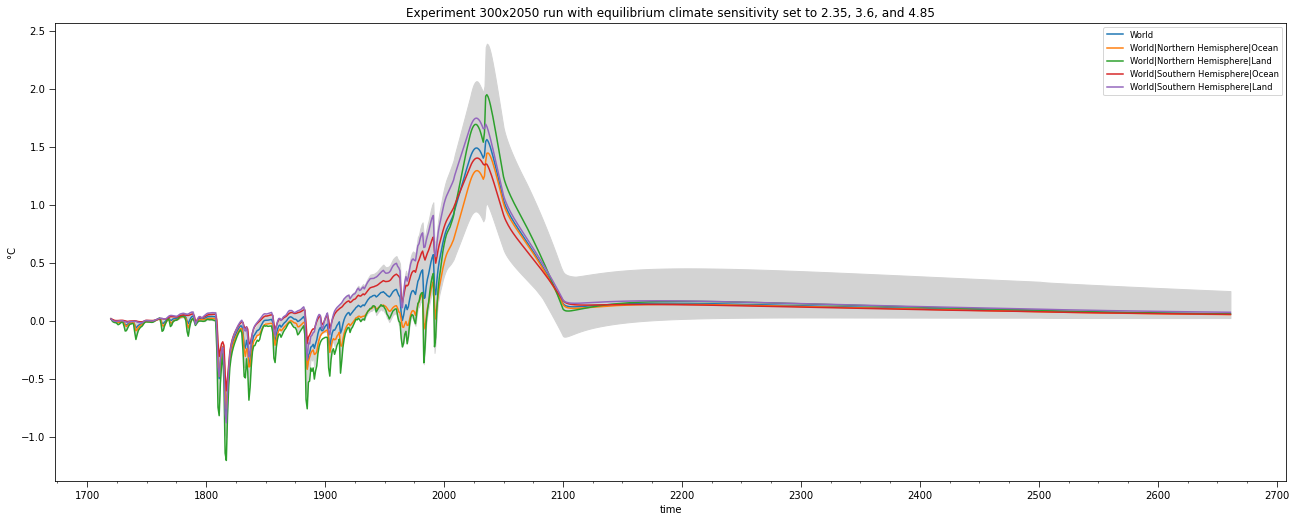

In [43]:
mlocator = mdates.YearLocator(100, month=1, day=1)
minloc = mdates.YearLocator(25, month=1, day=1)
formatter = mdates.ConciseDateFormatter(mlocator)

fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(18, 7))
runsdf['default'].filter(**filtering).lineplot( x="time", ax=ax, hue='region')
ax.tick_params(which='major', width=0.75, length=6)
ax.xaxis.set_major_locator(mlocator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(minloc)
ax.legend(fontsize="small")
plt.tight_layout(pad=0.6, h_pad=1.5)
plt.fill_between(
    runsdf['default'].filter(**filtering, region='World')['time'],
    runsdf['low'].filter(**filtering).timeseries().min().values.squeeze(),
    runsdf['high'].filter(**filtering).timeseries().max().values.squeeze(),
    color="lightgray",
)
plt.title(
    (f"Experiment 300x2050 run with equilibrium climate sensitivity set to {lsitv}, {sitv}, and {hsitv}")
)
plt.ylabel("°C");